In [1]:
print("Let's get started ;)")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(69)
torch.manual_seed(69)
torch.cuda.manual_seed_all(69)
np.random.seed(69)

Let's get started ;)


In [6]:
# PartialConv2d
class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(PartialConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None
        self.mask_conv = nn.Conv2d(1, 1, kernel_size, stride, padding, bias=False)
        self.mask_conv.weight.data.fill_(1.0)
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, x, mask):
        masked_x = x * mask
        conv_output = self.conv(masked_x)
        mask_sum = self.mask_conv(mask)
        eps = 1e-5
        scaling = self.conv.kernel_size[0] * self.conv.kernel_size[1] / (mask_sum + eps)
        output = conv_output * scaling
        if self.bias is not None:
            output = output + self.bias.view(1, -1, 1, 1)
        output = output * (mask_sum > 0).float()
        updated_mask = (mask_sum > 0).float()
        return output, updated_mask

# EncoderBlock
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(EncoderBlock, self).__init__()
        self.conv1 = PartialConv2d(in_ch, out_ch, 3, padding=1)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.conv2 = PartialConv2d(out_ch, out_ch, 3, padding=1)
        self.relu2 = nn.LeakyReLU(inplace=True)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, mask):
        x, mask = self.conv1(x, mask)
        x = self.relu1(x)
        x, mask = self.conv2(x, mask)
        x = self.relu2(x)
        x_pool = self.pool(x)
        mask_pool = self.pool(mask)
        return x_pool, mask_pool, x

# DecoderBlock
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv1 = PartialConv2d(out_ch + out_ch, out_ch, 3, padding=1)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.conv2 = PartialConv2d(out_ch, out_ch, 3, padding=1)
        self.relu2 = nn.LeakyReLU(inplace=True)

    def forward(self, x, mask, skip_x):
        x = self.upconv(x)
        mask = F.interpolate(mask, size=x.shape[2:], mode='nearest')
        x = torch.cat([x, skip_x], dim=1)
        x, mask = self.conv1(x, mask)
        x = self.relu1(x)
        x, mask = self.conv2(x, mask)
        x = self.relu2(x)
        return x, mask

# PartialConvUNet
class PartialConvUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(PartialConvUNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 32)
        self.enc2 = EncoderBlock(32, 64)
        self.enc3 = EncoderBlock(64, 128)
        self.bottleneck_conv1 = PartialConv2d(128, 256, 3, padding=1)
        self.bottleneck_relu1 = nn.LeakyReLU(inplace=True)
        self.bottleneck_conv2 = PartialConv2d(256, 256, 3, padding=1)
        self.bottleneck_relu2 = nn.LeakyReLU(inplace=True)
        self.dec3 = DecoderBlock(256, 128)
        self.dec2 = DecoderBlock(128, 64)
        self.dec1 = DecoderBlock(64, 32)
        self.final_conv = PartialConv2d(32, out_channels, 1)

    def forward(self, x, mask):
        x1, mask1, skip1 = self.enc1(x, mask)
        x2, mask2, skip2 = self.enc2(x1, mask1)
        x3, mask3, skip3 = self.enc3(x2, mask2)
        x, mask = self.bottleneck_conv1(x3, mask3)
        x = self.bottleneck_relu1(x)
        x, mask = self.bottleneck_conv2(x, mask)
        x = self.bottleneck_relu2(x)
        x, mask = self.dec3(x, mask, skip3)
        x, mask = self.dec2(x, mask, skip2)
        x, mask = self.dec1(x, mask, skip1)
        x, _ = self.final_conv(x, mask)
        return x

# Discriminator (Critic for WGAN-GP)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=0)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = self.conv5(x)
        return x

# Gradient Penalty for WGAN-GP
def compute_gradient_penalty(discriminator, real, fake, device):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolates = alpha * real + (1 - alpha) * fake
    interpolates.requires_grad_(True)
    disc_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Generator Loss
def generator_loss(pred, target, mask, disc_output, lambda_adv=0.01):
    mask = mask.expand(-1, pred.shape[1], -1, -1)
    valid = mask == 1
    hole = mask == 0
    loss_valid = torch.mean(torch.abs(pred[valid] - target[valid])) if torch.any(valid) else 0
    loss_hole = torch.mean(torch.abs(pred[hole] - target[hole])) if torch.any(hole) else 0
    recon_loss = loss_valid + 6 * loss_hole
    adv_loss = -torch.mean(disc_output)
    return recon_loss+lambda_adv * adv_loss

# Reconstruction Loss for Validation and Test
def reconstruction_loss(pred, target, mask):
    mask = mask.expand(-1, pred.shape[1], -1, -1)
    valid = mask == 1
    hole = mask == 0
    loss_valid = torch.mean(torch.abs(pred[valid] - target[valid])) if torch.any(valid) else 0
    loss_hole = torch.mean(torch.abs(pred[hole] - target[hole])) if torch.any(hole) else 0
    # loss_valid = F.l1_loss(pred[valid], target[valid]) if torch.any(valid) else torch.tensor(0.0, device=pred.device)
    # loss_hole = F.l1_loss(pred[hole], target[hole]) if torch.any(hole) else torch.tensor(0.0, device=pred.device)
    
    recon_loss = loss_valid + 3 * loss_hole
    return recon_loss

# InpaintingDataset
class InpaintingDataset(Dataset):
    def __init__(self, corrupted_dir, true_dir, transform=None):
        self.corrupted_dir = corrupted_dir
        self.true_dir = true_dir
        self.transform = transform
        self.filenames = sorted(os.listdir(corrupted_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        corrupted_path = os.path.join(self.corrupted_dir, self.filenames[idx])
        true_path = os.path.join(self.true_dir, self.filenames[idx])
        corrupted_img = Image.open(corrupted_path).convert('RGB')
        true_img = Image.open(true_path).convert('RGB')
        if self.transform:
            corrupted_img = self.transform(corrupted_img)
            true_img = self.transform(true_img)
        corrupted_np = (corrupted_img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        blurred = cv2.medianBlur(corrupted_np, ksize=5)
        white_lower = np.array([245, 245, 245], dtype=np.uint8)
        white_upper = np.array([255, 255, 255], dtype=np.uint8)
        black_lower = np.array([0, 0, 0], dtype=np.uint8)
        black_upper = np.array([10, 10, 10], dtype=np.uint8)
        white_mask = cv2.inRange(blurred, white_lower, white_upper)
        black_mask = cv2.inRange(blurred, black_lower, black_upper)
        combined_mask = cv2.bitwise_or(white_mask, black_mask)
        mask_np = (combined_mask == 0).astype(np.float32)
        mask = torch.from_numpy(mask_np).unsqueeze(0)
        return corrupted_img, mask, true_img

# Main Training Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor()
    ])

    # Dataset and Splitting
    corrupted_dir = '/kaggle/input/gan-training-dataset-car-dashboard/All_Data/processed_images'
    true_dir = '/kaggle/input/gan-training-dataset-car-dashboard/All_Data/true_images'
    dataset = InpaintingDataset(corrupted_dir, true_dir, transform=transform)
    N = len(dataset)
    train_size = int(0.8 * N)
    val_size = int(0.1 * N)
    test_size = N - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=210, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=210, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=210, shuffle=False)

    # Model Initialization
    generator = PartialConvUNet(in_channels=3, out_channels=3).to(device)
    discriminator = Discriminator(in_channels=3).to(device)
    generator.load_state_dict(torch.load('generator.pth'))
    discriminator.load_state_dict(torch.load('discriminator.pth'))
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0, 0.9))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0, 0.9))

    # Training Parameters
    num_epochs = 100
    g_save_path = 'generator.pth'
    d_save_path = 'discriminator.pth'
    lambda_gp = 10
    n_critic = 5

    # Training Loop
    for epoch in range(num_epochs):
        start_time = time.time()
        generator.train()
        discriminator.train()
        train_g_loss = 0
        train_d_loss = 0

        # Training
        for batch in train_loader:
            corrupted, mask, target = [x.to(device) for x in batch]
            # Train critic
            pred_detached = generator(corrupted, mask).detach()
            for _ in range(n_critic):
                d_optimizer.zero_grad()
                disc_real = discriminator(target)
                disc_fake = discriminator(pred_detached)
                gradient_penalty = compute_gradient_penalty(discriminator, target, pred_detached, device)
                d_loss = torch.mean(disc_fake) - torch.mean(disc_real) + lambda_gp * gradient_penalty
                d_loss.backward()
                d_optimizer.step()
                train_d_loss += d_loss.item()

            # Train generator
            g_optimizer.zero_grad()
            pred = generator(corrupted, mask)
            disc_fake = discriminator(pred)
            g_loss = generator_loss(pred, target, mask, disc_fake, lambda_adv=0.01)
            g_loss.backward()
            g_optimizer.step()
            train_g_loss += g_loss.item()

        # Average Training Losses
        train_g_loss /= len(train_loader)
        train_d_loss /= len(train_loader) * n_critic

        # Validation
        generator.eval()
        val_recon_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                corrupted, mask, target = [x.to(device) for x in batch]
                pred = generator(corrupted, mask)
                recon_loss = reconstruction_loss(pred, target, mask)
                val_recon_loss += recon_loss.item()
            val_recon_loss /= len(val_loader)

            # Display One Validation Sample
            corrupted, mask, target = next(iter(val_loader))
            corrupted, mask, target = corrupted.to(device), mask.to(device), target.to(device)
            pred = generator(corrupted, mask)
            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(corrupted[69].permute(1, 2, 0).cpu().numpy())
            ax[0].set_title("1")
            ax[0].axis('off')
            ax[1].imshow(corrupted[70].permute(1, 2, 0).cpu().numpy())
            ax[1].set_title("2")
            ax[1].axis('off')
            ax[2].imshow(corrupted[71].permute(1, 2, 0).cpu().numpy())
            ax[2].set_title("3")
            ax[2].axis('off')
            ax[3].imshow(corrupted[72].permute(1, 2, 0).cpu().numpy())
            ax[3].set_title("4")
            ax[3].axis('off')
            plt.show()

        # Time and Logging
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Train G_Loss: {train_g_loss:.4f}, Train D_Loss: {train_d_loss:.4f}, Val Recon Loss: {val_recon_loss:.4f}, Time: {epoch_time:.2f}s')

        # Save Models
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)

    # Test Evaluation
    generator.eval()
    test_recon_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            corrupted, mask, target = [x.to(device) for x in batch]
            pred = generator(corrupted, mask)
            recon_loss = reconstruction_loss(pred, target, mask)
            test_recon_loss += recon_loss.item()
        test_recon_loss /= len(test_loader)
    print(f'Test Recon Loss: {test_recon_loss:.4f}')

print("Interpreted successfully")

Interpreted successfully


<ipython-input-6-9f20068c232e>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))
<ipython-input-6-9f20068c232e>:212: 

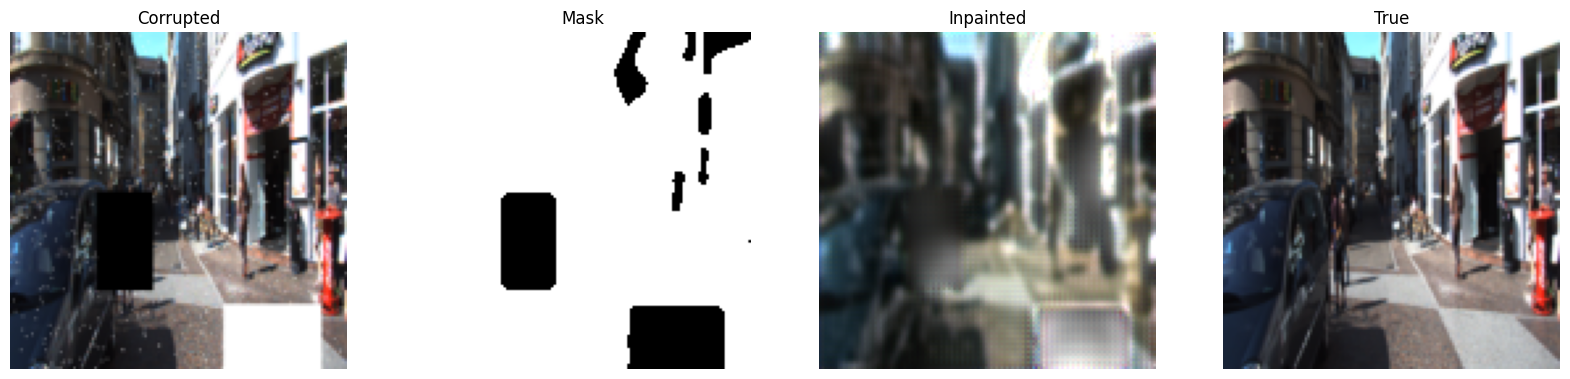

Epoch [1/100], Train G_Loss: 0.8939, Train D_Loss: -0.3468, Val Recon Loss: 0.4454, Time: 156.51s


In [ ]:
main()

In [ ]:
/kaggle/input/gan-training-dataset-car-dashboard
/kaggle/working/discriminator.pth